In [32]:
# basic python system/path library
import os
import glob
import shutil
from collections import defaultdict, OrderedDict
import time

# numerical libraries
import numpy as np
import pandas as pd

# HTTP library
import requests

# Compression libraries
import zipfile
import tarfile
import gzip

# SQLite database library
import sqlite3

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# database libraries
import pyodbc
# database abstraction library
import sqlalchemy
from sqlalchemy.engine import URL
from sqlalchemy import create_engine

# Geographical processing data
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point

## Parámetros del notebook

In [17]:
# Ruta al fichero de las ubicaciones de las estaciones de las que se quiere obtener más información
locations_file = '../datos/Point_Sampling_Murcia_desc.txt'
# Dirección web (URL) del fichero que continene las medidas interpoladas de precicitación en una malla de 5x5 km
precipitations_url = 'https://www.aemet.es/documentos/es/serviciosclimaticos/cambio_climat/datos_diarios/dato_observacional/rejilla_5km/v2/Serie_AEMET_v2_pcp_1951a2020_txt.tar.gz'
# Dirección web (URL) del fichero comprimido (ZIP) que contiene el histórico de las medidas 
# piezométricas registradas en la web del Ministerio de Transición Ecologica y Reto Demográfico
piezometry_url = 'https://www.miteco.gob.es/es/cartografia-y-sig/ide/descargas/basedatospiezometria_tcm30-533415.zip'
# Directorio de salida para los resultados
output_dir = 'C:/Users/marve/Documents/desarrollos/IGME/SARAI/resultados'
# Directorio de datos para los resultados
data_dir = 'C:/Users/marve/Documents/desarrollos/IGME/SARAI/datos'
# Localización de la base de datos SQLite
db_path = os.path.join(data_dir, 'pcp_red_SPAIN_1951-2020.sqlite')

## Funciones

In [4]:
def unzip(path_zip, unzip_dir, password=None):
    """
    """
    file_zip = zipfile.ZipFile(path_zip, "r")
    try:
        print(f'"{path_zip}" content:')
        print(file_zip.namelist())
        file_zip.extractall(pwd=password, path=unzip_dir)
    except:
        pass
    file_zip.close()
    
    return 0

In [5]:
def df_to_gdf(df, coordx='X', coordy='Y', sr='epsg:4326'):
    """
    """
    geometry = gpd.points_from_xy(df[coordx], df[coordy])
    # geometry = [gpd.Point(x, y) for x, y in zip(df[coordx], df[coordy])]
    # crs = {'init': sr} #http://www.spatialreference.org/ref/epsg/4326/ # DEPRECATED
    return gpd.GeoDataFrame(df, crs=sr, geometry=geometry)

In [6]:
def read_locations(path, coordx='X', coordy='Y', sep=';', decimal=',', sr='epsg:4326'):
    """
    Esta función lee un fichero en formato CSV que contiene medidas de valores registrados 
    en objetos puntales y devuelve un objeto de tipo 'GeoDataFrame'.
    
    Como parámetros de entrada:
        - path (str): ruta al fichero CSV que se desea leer.
        - coordx (str): campo que contiene la coordenada X de la posición del objeto puntual. 
          Por defecto toma el valor 'X'.
        - coordy (str): campo que contiene la coordenada Y de la posición del objeto puntual. 
          Por defecto toma el valor 'Y'.
        - sep (str): carácter usado para separar campos en una línea. Por defecto ';'.
        - decimal (str): carácter usado para separar la parte entera de la decimal en un 
          campo de tipo numérico. Por defecto toma el valor ','.
        - sr (str): Sistema de Referencia en el que vienen dadas las coordenadas X e Y de los 
          puntos representados en el fichero. Por defecto toma el valor 'epsg:4326'.
          
    Como parámetros de salida:
        - objeto (GeoDataFrame): subtipo de un objeto DataFrame de Pandas. Contiene una columna
        de tipo Geometry con las coordenadas de los puntos representados.
    """
    df = pd.read_csv(path, sep=sep, decimal=decimal)

    print(df[coordx])
    print(f'{df[coordx].values[0]}, {df[coordy].values[0]}')
    
    return df_to_gdf(df, coordx=coordx, coordy=coordy, sr=sr)

In [7]:
def get_url(url, download_dir):
    """
    Descarga el fichero apuntado por 'url' en el directorio 'download_dir'.
    Devuelve el número de caracteres descargados.
    """
    
    prefix, name = os.path.split(url)
    
    if not os.path.exists(download_dir):
        try:
            os.makedirs(download_dir, exist_ok=True)
        except FileExistsError:
            # print(f"ERROR (get_url): Can not generate output directory '{download_dir}'.")
            raise
            # return -1
    
    download_path = os.path.join(download_dir, name)
    
    r = requests.get(url)
    #retrieving data from the URL using get method

    with open(download_path, 'wb') as f:
        #giving a name and saving it in any required format
        #opening the file in write mode
        f.write(r.content) 
        #writes the URL contents from the server
    
    return len(r.content)

In [8]:
def read_db_piezometry(path):
    """
    """
    # Parámetros de conexion a MS Access
    # myDataSources = pyodbc.dataSources()
    # access_driver = myDataSources['MS Access Database']
    
    # Conexión a MS Access
    # cnxn = pyodbc.connect(Driver = access_driver, DBQ = path)
    path = path.replace(r'\\', '/')
    print(f'path={path}')
    #conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
    #        r'DBQ={};'.format(path))
    
    """
    connection_string = r'DRIVER={};DBQ={};UID="";PWD="";'.format('Microsoft Access Driver (*.mdb, *.accdb)', path)
    connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
    engine = create_engine(connection_url)
    cnxn = engine.raw_connection()
    """
    cnxn = pyodbc.connect(r'DRIVER={};DBQ={};UID="";PWD="";'.format('Microsoft Access Driver (*.mdb, *.accdb)', path))
    
    
    cursor = cnxn.cursor()
    for table_name in cursor.tables(tableType='TABLE'):
        print(table_name)
    
    # Table 01_Piezometros
    sql = "SELECT * FROM 01_Piezometros"
    print(sql)
    cursor.execute(sql)
    df_piezometros = pd.read_sql(sql, cnxn)
    
    
    # Table 02_Niveles
    sql = "SELECT * FROM 02_Niveles"
    print(sql)
    cursor.execute(sql)
    df_niveles = pd.read_sql(sql, cnxn)
    
    """
    # Consulta sobre los datos de Piezometros a MS Access
    query_piezometros = pd.read_sql_table('01_Piezometros', cnxn)
    
    # Paso a dataframe
    df_piezometros = pd.DataFrame(query_piezometros)
    print(df_piezometros)
    
    # Consulta sobre las medias de piezometría a MS Access
    query_niveles = pd.read_sql_table('02_Niveles', cnxn, parse_dates={'FechaP':'%Y-%m-%d'})
    
    # Paso a dataframe
    df_niveles = pd.DataFrame(query_niveles)
    print(df_niveles)
    """
    return df_piezometros, df_niveles
    
    

## Main code

### Reading input data

#### 1. Puntos de muestreo

Es un fichero en formato CSV que contiene información de objetos puntuales. Los campos están separados por ';'

In [9]:
df_loc = pd.read_csv(locations_file, sep=';', decimal=',')

Establezco como índice del *DataFrame* la columna 'FID'

In [51]:
df_loc = df_loc.set_index('FID', drop=False)

Información sobre el objeto GeoDataFrame generado tras la lectura del fichero.

In [52]:
print(df_loc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2194 entries, 0 to 2193
Data columns (total 38 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FID         2194 non-null   int64   
 1   fid_        2194 non-null   int64   
 2   E           2194 non-null   float64 
 3   N           2194 non-null   float64 
 4   ADA_ID      2194 non-null   int64   
 5   VELOCITY    2194 non-null   float64 
 6   X           2194 non-null   float64 
 7   Y           2194 non-null   float64 
 8   SATELLITE   2194 non-null   object  
 9   TRACK       2194 non-null   int64   
 10  FRAME       2194 non-null   object  
 11  INIT_DATE   2194 non-null   int64   
 12  FINAL_DATE  2194 non-null   int64   
 13  PIXEL_SIZE  2194 non-null   int64   
 14  SOFTWARE    2194 non-null   object  
 15  PAPERS      2194 non-null   object  
 16  COHERENCE   2194 non-null   float64 
 17  Lon_ETRS89  2194 non-null   float64 
 18  Lat_ETRS89  2194 non-null   float64 
 19  MEAN_V

Me llama la atención el campo **GEOMETRY**. Compruebo su contenido.

In [54]:
if 'GEOMETRY' in df_loc.columns:
    print(df_loc.GEOMETRY)

Dado que no contiene información al respecto de la geometría (punto, polígono...), lo elimino.

In [56]:
if 'GEOMETRY' in df_loc.columns:
    df_loc = df_loc.drop('GEOMETRY', axis=1)

Accedo de nuevo al conjunto de datos. Quiero comprobar qué valores tienen las coordenadas **X** e **Y** para asignar al conjunto de datos un Sistema de Referencia adecuado.

In [57]:
print(df_loc.X)
print(f'{df_loc.X.values[0]}, {df_loc.Y.values[0]}')

FID
0      -1.77625
1      -1.77542
2      -1.77375
3      -1.77375
4      -1.77375
         ...   
2189   -0.74542
2190   -0.74458
2191   -0.74458
2192   -0.74458
2193   -0.74458
Name: X, Length: 2194, dtype: float64
-1.77625, 37.57875


Creo un *GeoDataFrame*, generando una columna de geometría a partir de las Coordenadas Geográficas dadas por los campos 'X' e 'Y' y el sistema de coordenadas 'EPSG:4326'.

In [58]:
geometry = gpd.points_from_xy(df_loc.X, df_loc.Y)
gdf_loc = gpd.GeoDataFrame(df_loc, crs='EPSG:4326', geometry=geometry)

Muestro de las primeras 5 filas del objeto *GeoDataFrame*. Ahora, se ha creado una nueva columna **geometry** que define cada objeto representado en los registros del fichero (puntos).

In [59]:
print(gdf_loc.head())

     FID  fid_              E             N  ADA_ID  VELOCITY        X  \
FID                                                                      
0      0     3  608055.779631  4.159782e+06      30   -0.6987 -1.77625   
1      1     4  608136.302137  4.159228e+06      30   -0.7051 -1.77542   
2      2     7  608278.954313  4.159600e+06      30   -1.1283 -1.77375   
3      3     8  608281.358457  4.159415e+06      30   -1.0702 -1.77375   
4      4     9  608283.776992  4.159230e+06      30   -0.9726 -1.77375   

            Y SATELLITE  TRACK  ... red_trans  Moves  SubsEsp  QAFI_trace  \
FID                             ...                                         
0    37.57875        S1      8  ...         0                           1   
1    37.57375        S1      8  ...         0                           1   
2    37.57708        S1      8  ...         0                           1   
3    37.57542        S1      8  ...         0                           1   
4    37.57375      

Genero una gráfica con las ubicaciones del fichero.

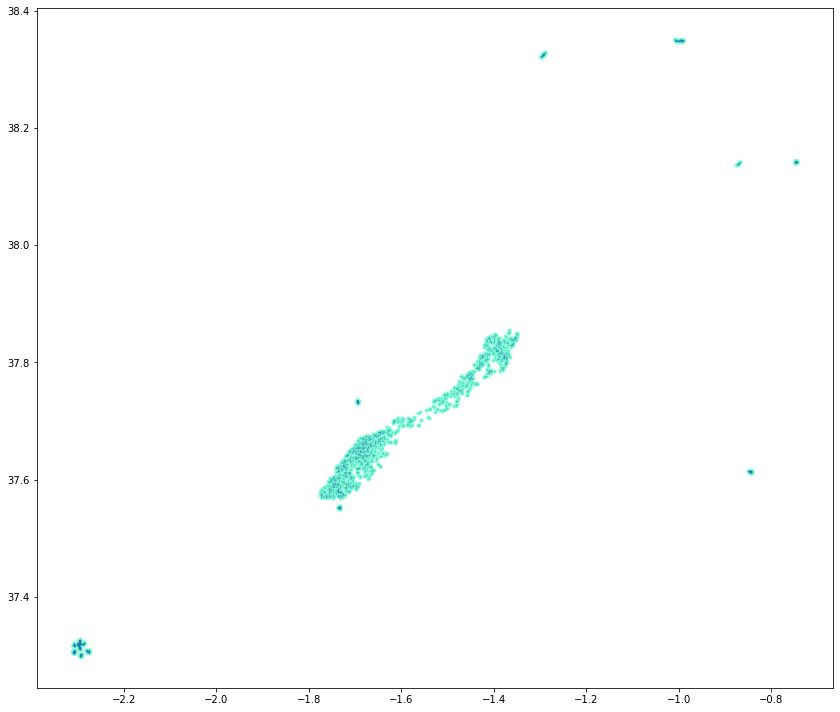

In [60]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_loc.plot(marker='.', color='aquamarine', edgecolor='aquamarine')

# We can now plot our ``GeoDataFrame``.
gdf_loc.plot(ax=ax, alpha=0.3, marker='.', markersize=1)

plt.show()

#### 2. Precipitationes

La medida de las precipitaciones se obtiene a partir de la URL proporcionada a través de la
variable **precipitations_url**. Es un fichero empaquetado y comprimido en formato *.tar.gz*.
Contiene la medida de interpolada en una malla de 5x5 km de la precipitación diaria registrada
por la AEMET.

In [61]:
root, name_prep = os.path.split(precipitations_url)
precip_path = os.path.join(data_dir, name_prep)

print(f"Fichero de precipitaciones: '{precip_path}'")

res_get = 1

if not os.path.exists(precip_path):
    print(f"Descargando: '{precipitations_url}'. Por favor, espere.")
    res_ges = get_url(precipitations_url, data_dir)

if res_get > 0:
    # descomprimo el fichero
    # open file
    precip_compress = tarfile.open(precip_path)
  
    # extracting file
    precip_compress.extractall(data_dir)
  
    precip_compress.close()
    
# gunzip fichero de datos
patron = os.path.join(data_dir, '*.txt.gz')
print(f'Buscando ficheros con el patron: {patron}')
precip_gz = glob.glob(patron)
precip_path = None
if len(precip_gz):
    print(f'Fichero a desempaquetar: {precip_gz[0]}')
    precip_path = precip_gz[0][:-3]
    if not os.path.exists(precip_path):
        with gzip.open(precip_gz[0], 'rb') as f_in:
            with open(precip_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

Fichero de precipitaciones: 'C:/Users/marve/Documents/desarrollos/IGME/SARAI/datos\Serie_AEMET_v2_pcp_1951a2020_txt.tar.gz'
Buscando ficheros con el patron: C:/Users/marve/Documents/desarrollos/IGME/SARAI/datos\*.txt.gz
Fichero a desempaquetar: C:/Users/marve/Documents/desarrollos/IGME/SARAI/datos\pcp_red_SPAIN_1951-2020.txt.gz


Leo la primera fila del fichero de precipitación

In [62]:
precipitacion = open(precip_path)
first = precipitacion.readline()
print(len(first.split()))

16157


Leo todo el contenido del fichero. Muestro el tiempo que se ha tardado en realizar esta operación.

Ahora, tengo que leer y filtrar un fichero de 3 GB! Es un fichero muy pesado.

Como estrategia de trabajo podría tomarse la siguiente:
1. Cargar las ubicaciones de la malla (fichero *maestro_red_hr_SPAIN.txt*) en un fichero GeoPandas.
2. Para cada ubicación, buscar la más cercana en un radio de 5 km.
3. Seleccionar las medidas de precipitación interpolada tomando sólo las que vienen dadas por el índice de la posición más cercana.

##### 1. Carga de las ubicaciones interpoladas

In [21]:
df_master_precip = pd.read_csv(os.path.join(data_dir, 'maestro_red_hr_SPAIN.txt'), header=None, delim_whitespace=True)
df_master_precip.columns = ['ID', 'longitude', 'latitude', 'height']
print(df_master_precip)

          ID  longitude  latitude  height
0          1     -2.948    35.307   102.0
1          2     -5.323    35.898    58.0
2          3     -5.630    36.049   124.0
3          4     -5.568    36.049   186.0
4          5     -5.507    36.049   163.0
...      ...        ...       ...     ...
16151  16152     -7.866    43.736    70.0
16152  16153     -7.796    43.737    40.0
16153  16154     -7.727    43.738    57.0
16154  16155     -7.658    43.739    66.0
16155  16156     -7.520    43.740     1.0

[16156 rows x 4 columns]


'longitude' y 'latitude' contienen coordenadas geográficas. Generamos el correspondiente *GeoDataFrame* a partir de esas columnas.

In [23]:
geometry = gpd.points_from_xy(df_master_precip.longitude, df_master_precip.latitude)
gdf_master_precip = gpd.GeoDataFrame(df_master_precip, crs='EPSG:4326', geometry=geometry)

In [24]:
print(gdf_master_precip.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16156 entries, 0 to 16155
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         16156 non-null  int64   
 1   longitude  16156 non-null  float64 
 2   latitude   16156 non-null  float64 
 3   height     16156 non-null  float64 
 4   geometry   16156 non-null  geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 631.2 KB
None


In [25]:
print(gdf_master_precip.head())

   ID  longitude  latitude  height                   geometry
0   1     -2.948    35.307   102.0  POINT (-2.94800 35.30700)
1   2     -5.323    35.898    58.0  POINT (-5.32300 35.89800)
2   3     -5.630    36.049   124.0  POINT (-5.63000 36.04900)
3   4     -5.568    36.049   186.0  POINT (-5.56800 36.04900)
4   5     -5.507    36.049   163.0  POINT (-5.50700 36.04900)


EPSG:4326 viene en grados. Tengo que reproyectar a otro Sistema de Refencia para obtener medidas en km (EPSG:25830, ETRS89 / UTM zone 30N)

In [26]:
gdf_loc = gdf_loc.to_crs('EPSG:25830')
gdf_master_precip = gdf_master_precip.to_crs('EPSG:25830')

Muestro la malla y los puntos de muestreo sobre los que vamos a trabajar.

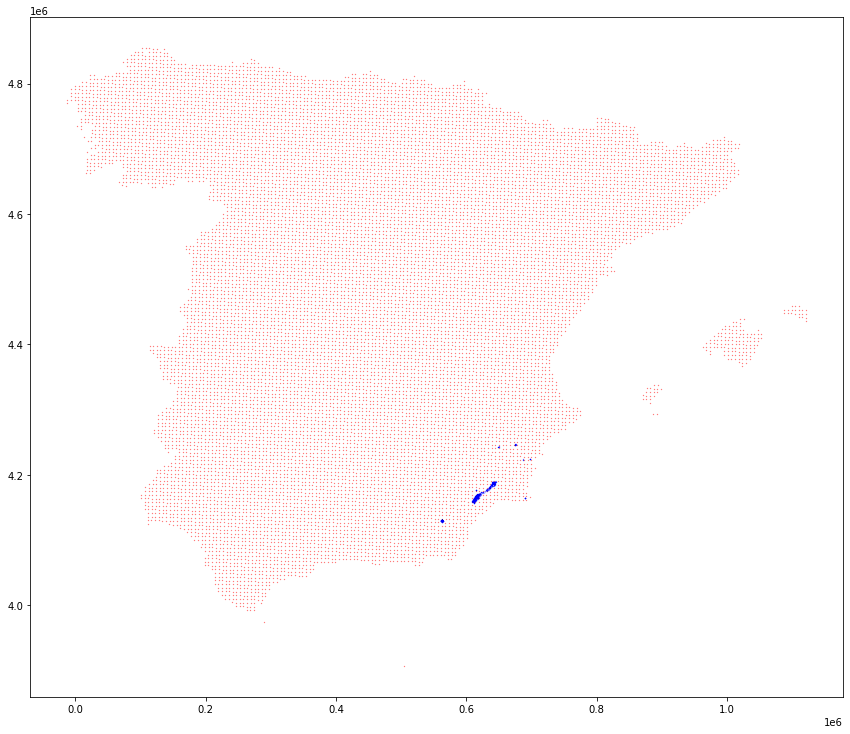

In [27]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_master_precip.plot(color='white', edgecolor='red', marker='.', markersize=0.2)

gdf_loc.plot(ax=ax, color='blue', alpha=0.3, marker='.', markersize=0.1)

plt.show()

**Limito la malla al cuadrado determinado por las coordenadas extremas de las localizaciones de muestreo.**

In [31]:
gdf_loc["buffered"] = gdf_loc.buffer(6000) # 6 km alrededor de cada punto

# cambio la geometría por defecto de puntos a buffers
gdf_loc = gdf_loc.set_geometry("buffered")

# muestro información sobre el geodataframe
print(gdf_loc.info())

# coordenadas extremas de los buffers
minx, miny, maxx, maxy = gdf_loc.total_bounds

print(f'(minx, miny, maxx, maxy) = ({minx}, {miny}, {maxx}, {maxy})')

# establezco de nuevo la geometría por defecto a la columna de puntos
gdf_loc = gdf_loc.set_geometry("geometry")

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 39 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FID         2194 non-null   int64   
 1   fid_        2194 non-null   int64   
 2   E           2194 non-null   float64 
 3   N           2194 non-null   float64 
 4   ADA_ID      2194 non-null   int64   
 5   VELOCITY    2194 non-null   float64 
 6   X           2194 non-null   float64 
 7   Y           2194 non-null   float64 
 8   SATELLITE   2194 non-null   object  
 9   TRACK       2194 non-null   int64   
 10  FRAME       2194 non-null   object  
 11  INIT_DATE   2194 non-null   int64   
 12  FINAL_DATE  2194 non-null   int64   
 13  PIXEL_SIZE  2194 non-null   int64   
 14  SOFTWARE    2194 non-null   object  
 15  PAPERS      2194 non-null   object  
 16  COHERENCE   2194 non-null   float64 
 17  Lon_ETRS89  2194 non-null   float64 
 18  Lat_ETRS89  2194 non-null   float64 
 19

Genero un polígono a partir de los límites obtenidos en el punto anterior

In [42]:
pol_geom = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny)])
polygon = gpd.GeoDataFrame(index=[0], crs='EPSG:25830', geometry=[pol_geom])  

Obtengo los puntos de la malla dentro de los límites

In [43]:
inside = gdf_master_precip.within(polygon.geometry[0])
print(f'Número de puntos dentro del área límite = {inside.sum()}')

Número de puntos dentro del área límite = 516


In [44]:
# filtro la malla de precipitaciones al área de interés
gdf_reduced_grid = gdf_master_precip[inside]

# reproyecto a ETRS 25830
gdf_reduced_grid = gdf_reduced_grid.to_crs('EPSG:25830')
print(f'Número de nodos = {len(gdf_reduced_grid.index)}')
print(gdf_reduced_grid.head())

Número de nodos = 516
        ID  longitude  latitude  height                        geometry
1198  1199     -2.359    37.290  1112.0  POINT (556816.646 4127236.357)
1199  1200     -2.297    37.288   903.0  POINT (562313.892 4127053.528)
1200  1201     -2.234    37.286   743.0  POINT (567900.092 4126875.018)
1201  1202     -2.171    37.284   665.0  POINT (573486.610 4126700.227)
1202  1203     -2.109    37.282   593.0  POINT (578984.798 4126528.319)


Genero de nuevo una gráfica con el subconjunto de nodos de precipitación y las estaciones de muestreo.

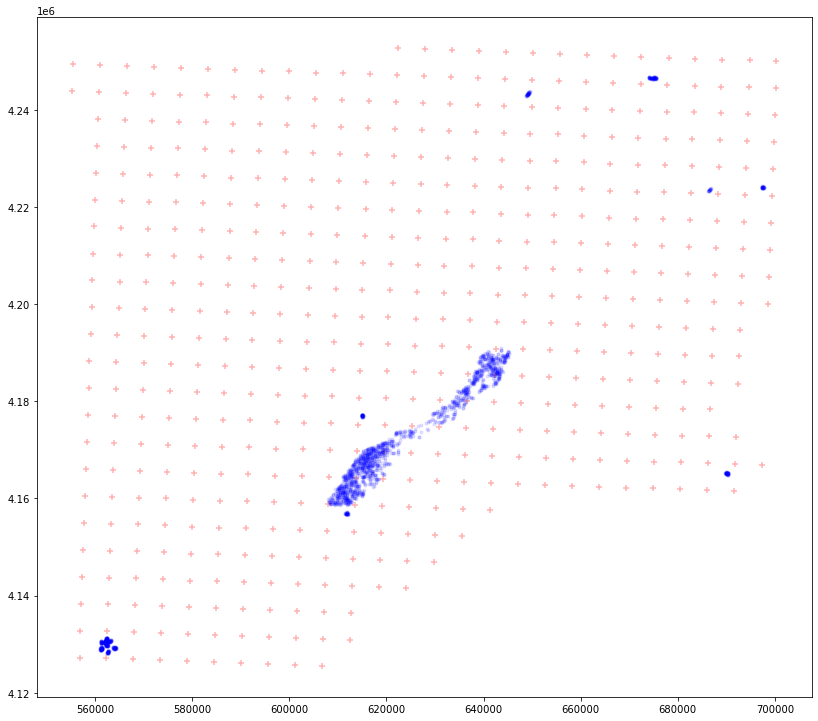

In [46]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_reduced_grid.plot(color='red', marker='+', alpha=0.3)

# gdf_reduced_grid.plot(ax=ax, marker='+')

gdf_loc.plot(ax=ax, color='blue', marker='.', alpha=0.1)

plt.show()

Zoom a las ubicaciones y su posición relativa a la malla de precipitaciones

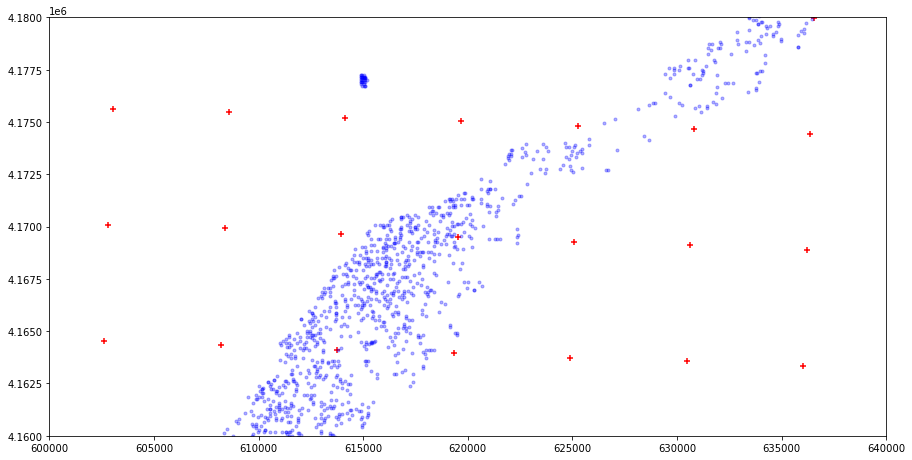

In [47]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_reduced_grid.plot(color='red', marker='+')

# gdf_reduced_grid.plot(ax=ax, marker='+')

gdf_loc.plot(ax=ax, color='blue', marker='.', alpha=0.3)


ax.set_xlim(600000, 640000)
ax.set_ylim(4160000, 4180000)
plt.show()



##### 2. Para cada ubicación, buscar la más cercana en un radio de 5 km.

In [48]:
# Comprobación del SR del GeoDataFrame
print(gdf_reduced_grid.crs)

EPSG:25830


In [49]:
print(f'Tamaño del DataFrame de lugares de muestreo (filas, columnas) = {gdf_loc.shape}')

Tamaño del DataFrame de lugares de muestreo (filas, columnas) = (2194, 39)


In [50]:
# Campos que forman parte del GeoDataFrame de nodos de precipitación dentro del área de estudio
print(gdf_reduced_grid.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 516 entries, 1198 to 3527
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         516 non-null    int64   
 1   longitude  516 non-null    float64 
 2   latitude   516 non-null    float64 
 3   height     516 non-null    float64 
 4   geometry   516 non-null    geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 24.2 KB
None


Trabajaremos punto por punto. Es decir, para cada localización de muestreo, buscaremos el nodo de precipitación más cercano.

In [227]:
# Diccionario de listas donde almacenaremos los resultados de puntos cercanos
pairs = defaultdict(list)

# para cada localización de medida...
for ind in gdf_loc.index:
    location = gdf_loc.loc[[ind]].geometry.values[0]
    # print(location)
    # Se busca el punto más cercano en la malla de precipitaciones
    dist = gdf_reduced_grid.geometry.distance(location)
    #print(f'Distancia mínima (m) = {dist.values.min()}')
    index_grid = gdf_reduced_grid.index[dist.values.argmin()]
    #print(gdf_reduced_grid.loc[[index_grid]])
    # Almacenamos en el diccionario los índices de las ubicaciones próximas y sus distancias
    pairs['index_location'].append(ind)
    pairs['index_grid'].append(index_grid)
    pairs['distance_m'].append(dist.values.min())

print(f'Número de distancias medidas = {len(pairs["distance_m"])}')
for l, g, d in zip(pairs['index_location'], pairs['index_grid'], pairs['distance_m']):
    print(f'(index_location, index_grid, distance_m) = ({l}, {g}, {d})')
    
# Guardo el diccionario de correspondencias como fichero temporal en el directorio de resultados
df_related_precip = pd.DataFrame.from_dict(pairs)
related_precip_path = os.path.join(output_dir, 'correspondencias_precipitaciones.csv')
df_related_precip.to_csv(related_precip_path, index=False)

Número de distancias medidas = 2194
(index_location, index_grid, distance_m) = (0, 1769, 973.156720553324)
(index_location, index_grid, distance_m) = (1, 1769, 438.87490098032947)
(index_location, index_grid, distance_m) = (2, 1769, 836.3893017463212)
(index_location, index_grid, distance_m) = (3, 1769, 666.3874284997938)
(index_location, index_grid, distance_m) = (4, 1769, 505.4971826246658)
(index_location, index_grid, distance_m) = (5, 1769, 318.7925249085946)
(index_location, index_grid, distance_m) = (6, 1769, 290.7985016869849)
(index_location, index_grid, distance_m) = (7, 1769, 1387.9821806841862)
(index_location, index_grid, distance_m) = (8, 1769, 622.9812772851079)
(index_location, index_grid, distance_m) = (9, 1769, 601.623572907578)
(index_location, index_grid, distance_m) = (10, 1769, 437.0262726991474)
(index_location, index_grid, distance_m) = (11, 1769, 1607.9864790955446)
(index_location, index_grid, distance_m) = (12, 1769, 718.4366450077755)
(index_location, index_g

(index_location, index_grid, distance_m) = (877, 1973, 602.5719705610579)
(index_location, index_grid, distance_m) = (878, 1868, 983.1480415221595)
(index_location, index_grid, distance_m) = (879, 1868, 892.3088264423495)
(index_location, index_grid, distance_m) = (880, 1973, 602.5715987254808)
(index_location, index_grid, distance_m) = (881, 1868, 2736.9961818413726)
(index_location, index_grid, distance_m) = (882, 1973, 1988.8458124184401)
(index_location, index_grid, distance_m) = (883, 1973, 602.5720362853637)
(index_location, index_grid, distance_m) = (884, 1973, 2727.7727788210104)
(index_location, index_grid, distance_m) = (885, 1973, 1529.7508240880286)
(index_location, index_grid, distance_m) = (886, 1973, 1812.4972375499044)
(index_location, index_grid, distance_m) = (887, 1973, 1536.7649445661232)
(index_location, index_grid, distance_m) = (888, 1973, 628.7945513799588)
(index_location, index_grid, distance_m) = (889, 1973, 189.3044910092761)
(index_location, index_grid, dis

(index_location, index_grid, distance_m) = (1451, 2287, 529.0825933328427)
(index_location, index_grid, distance_m) = (1452, 2287, 529.0825933328427)
(index_location, index_grid, distance_m) = (1453, 2390, 1787.8968166776724)
(index_location, index_grid, distance_m) = (1454, 2390, 1880.9495043925133)
(index_location, index_grid, distance_m) = (1455, 2287, 1058.2740468695167)
(index_location, index_grid, distance_m) = (1456, 2287, 804.7611297029086)
(index_location, index_grid, distance_m) = (1457, 2390, 1886.6311639631895)
(index_location, index_grid, distance_m) = (1458, 2287, 1285.307768495942)
(index_location, index_grid, distance_m) = (1459, 2287, 1170.8206764171769)
(index_location, index_grid, distance_m) = (1460, 2287, 1002.0533842682419)
(index_location, index_grid, distance_m) = (1461, 2287, 763.8949973580609)
(index_location, index_grid, distance_m) = (1462, 2287, 691.3349535844912)
(index_location, index_grid, distance_m) = (1463, 2287, 562.944872552437)
(index_location, ind

(index_location, index_grid, distance_m) = (1854, 1199, 1621.8220402121901)
(index_location, index_grid, distance_m) = (1855, 1199, 1621.8220402121901)
(index_location, index_grid, distance_m) = (1856, 1199, 1533.3301861863797)
(index_location, index_grid, distance_m) = (1857, 1199, 1445.2871867798835)
(index_location, index_grid, distance_m) = (1858, 1199, 1445.2871867798835)
(index_location, index_grid, distance_m) = (1859, 1199, 1269.8784355181363)
(index_location, index_grid, distance_m) = (1860, 1199, 1183.8182724255068)
(index_location, index_grid, distance_m) = (1861, 1290, 2058.0750757660912)
(index_location, index_grid, distance_m) = (1862, 1290, 2058.0750757660912)
(index_location, index_grid, distance_m) = (1863, 1290, 2149.5393763865895)
(index_location, index_grid, distance_m) = (1864, 1199, 1555.8528373819533)
(index_location, index_grid, distance_m) = (1865, 1199, 1555.8528373819533)
(index_location, index_grid, distance_m) = (1866, 1199, 1555.8528373819533)
(index_locat

In [228]:
print(f'Estructura del DataFrame de puntos asociados (registros, campos) = {df_related_precip.shape}')

Estructura del DataFrame de puntos asociados (registros, campos) = (2194, 3)


**Estadísticas sobre las distancias entre localizaciones de medida y nodos de la malla de precipitaciones**

In [229]:
dist = df_related_precip['distance_m'].values
message = '(media, desviación estándar, mediana, máximo, mínimo) = ({:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}) m'
print(message.format(dist.mean(), dist.std(), np.median(dist), dist.max(), dist.min()))

(media, desviación estándar, mediana, máximo, mínimo) = (2206.17, 693.94, 2300.40, 3846.36, 51.96) m


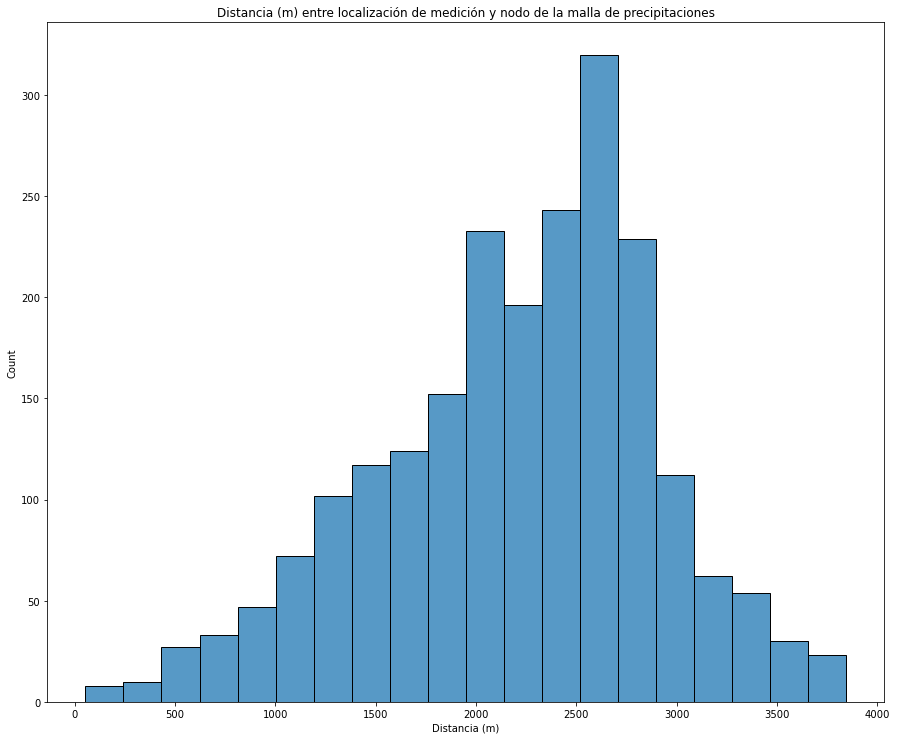

In [230]:
sns.histplot(df_related_precip['distance_m'].values, bins=20)
#plt.hist(pairs['distance_m'], bins=15)
plt.title('Distancia (m) entre localización de medición y nodo de la malla de precipitaciones')
plt.xlabel("Distancia (m)")
plt.show()

**Agrego esta información al dataframe de puntos de muestreo**

In [231]:
# nueva información
grid_ids = gdf_reduced_grid.loc[df_related_precip['index_grid'].values]['ID'].values
print(grid_ids)
print(len(grid_ids))
new_fields = {'ID_nodo_precip': grid_ids, 'dist_nodo_precip_m': df_related_precip['distance_m'].values}
new_df = pd.DataFrame.from_dict(new_fields)
# Información y muestra de los datos a agregar al DataFrame de puntos de muestreo (df_loc)
print(new_df.info())
print(new_df.head())
print(f'\nNúmero de líneas del dataframe = {len(new_df.index)}\n')

if 'ID_nodo_precip' not in df_loc.columns:
    # agregado de nueva información al DataFrame de puntos de muestreo
    df_loc = pd.concat([df_loc, new_df], axis=1, join='inner')
    
# Verificación
print(df_loc.info())

[1770 1770 1770 ... 3001 3001 3001]
2194
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_nodo_precip      2194 non-null   int64  
 1   dist_nodo_precip_m  2194 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 34.4 KB
None
   ID_nodo_precip  dist_nodo_precip_m
0            1770          973.156721
1            1770          438.874901
2            1770          836.389302
3            1770          666.387428
4            1770          505.497183

Número de líneas del dataframe = 2194

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   FID                 2194 non-null   int64   
 1   fid_                2194 non-null   int64   
 2   E                   2

##### 3. Generación del fichero histórico de precipitaciones para las localizaciones consideradas

Ahora que están identificadas las estaciones y su nodo de malla de precipitaciones más cercanas, hay que generar el fichero de salida con formato

DATE,FID1,FID2...,FIDN

Donde cada FID corresponde a las medidas de precipitaciones de una estación.

###### 3.1. Creando infraestructura en Base de Datos para almacenar información sobre los Puntos de Muestreo

In [232]:
"""  

# Esto ya lo hace automáticamente Pandas al insertar un DataFrame


# Creando tabla para almacenar los puntos de muestreo en la base de datos

conn = sqlite3.connect(db_path)
c = conn.cursor()

# diccionario de campos
fields = OrderedDict()
fields['FID'] = 'INT'
fields['fid_'] = 'INT'
fields['E'] = 'DECIMAL(20,10)'
fields['N'] = 'DECIMAL(20,10)'
fields['ADA_ID'] = 'INT'
fields['VELOCITY'] = 'DECIMAL(16,5)'
fields['X'] = 'DECIMAL(20,10)'
fields['Y'] = 'DECIMAL(20,10)'
fields['SATELLITE'] = 'VARCHAR(50)'
fields['GEOMETRY'] = 'VARCHAR(50)'
fields['TRACK'] = 'INT'
fields['FRAME'] = 'INT'
fields['INIT_DATE'] = 'DATE'
fields['FINAL_DATE'] = 'DATE'
fields['PIXEL_SIZE'] = 'DECIMAL(6,2)'
fields['SOFTWARE'] = 'VARCHAR(100)'
fields['PAPERS'] = 'VARCHAR(500)'
fields['COHERENCE'] = 'DECIMAL(5,2)'
fields['Lon_ETRS89'] = 'DECIMAL(20,10)'
fields['Lat_ETRS89'] = 'DECIMAL(20,10)'
fields['MEAN_VLOS'] = 'DECIMAL(10,5)'
fields['Lon_WGS84'] = 'DECIMAL(12,7)'
fields['Lat_WGS84'] = 'DECIMAL(12,7)'
fields['PS_ID'] = 'VARCHAR(100)'
fields['DESC_UNIT'] = 'VARCHAR(256)'
fields['GeoUnif'] = 'VARCHAR(256)'
fields['Masas_subt'] = 'BOOLEAN'
fields['aguas_supf'] = 'BOOLEAN'
fields['emb_aux'] = 'BOOLEAN'
fields['red_trans'] = 'BOOLEAN'
fields['Moves'] = 'BOOLEAN'
fields['SubsEsp'] = 'BOOLEAN'
fields['QAFI_trace'] = 'BOOLEAN'
fields['QAFI_vecto'] = 'BOOLEAN'
fields['CODE_18'] = 'INT'
fields['pendientes'] = 'DECIMAL(10,5)'
fields['Subsidence'] = 'INT'
fields['Proceso'] = 'VARCHAR(100)'
fields['ID_nodo_precip'] = 'INT'
fields['dist_nodo_precip_m'] = 'DECIMAL(10,2)'
fields['ID_nodo_piezo'] = 'INT'
fields['dist_nodo_piezo_m'] = 'DECIMAL(10,2)'
list_fields = []
for k, v in fields.items():
    list_fields.append(f'`{k}` {v}')
sql = f'CREATE TABLE IF NOT EXISTS punto_muestreo ({", ".join(list_fields)}, PRIMARY KEY (`FID`))'
print(sql)


c.execute(sql)
conn.commit()

conn.close()
"""

'  \n\n# Esto ya lo hace automáticamente Pandas al insertar un DataFrame\n\n\n# Creando tabla para almacenar los puntos de muestreo en la base de datos\n\nconn = sqlite3.connect(db_path)\nc = conn.cursor()\n\n# diccionario de campos\nfields = OrderedDict()\nfields[\'FID\'] = \'INT\'\nfields[\'fid_\'] = \'INT\'\nfields[\'E\'] = \'DECIMAL(20,10)\'\nfields[\'N\'] = \'DECIMAL(20,10)\'\nfields[\'ADA_ID\'] = \'INT\'\nfields[\'VELOCITY\'] = \'DECIMAL(16,5)\'\nfields[\'X\'] = \'DECIMAL(20,10)\'\nfields[\'Y\'] = \'DECIMAL(20,10)\'\nfields[\'SATELLITE\'] = \'VARCHAR(50)\'\nfields[\'GEOMETRY\'] = \'VARCHAR(50)\'\nfields[\'TRACK\'] = \'INT\'\nfields[\'FRAME\'] = \'INT\'\nfields[\'INIT_DATE\'] = \'DATE\'\nfields[\'FINAL_DATE\'] = \'DATE\'\nfields[\'PIXEL_SIZE\'] = \'DECIMAL(6,2)\'\nfields[\'SOFTWARE\'] = \'VARCHAR(100)\'\nfields[\'PAPERS\'] = \'VARCHAR(500)\'\nfields[\'COHERENCE\'] = \'DECIMAL(5,2)\'\nfields[\'Lon_ETRS89\'] = \'DECIMAL(20,10)\'\nfields[\'Lat_ETRS89\'] = \'DECIMAL(20,10)\'\nfields[\

In [233]:
print(df_loc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   FID                 2194 non-null   int64   
 1   fid_                2194 non-null   int64   
 2   E                   2194 non-null   float64 
 3   N                   2194 non-null   float64 
 4   ADA_ID              2194 non-null   int64   
 5   VELOCITY            2194 non-null   float64 
 6   X                   2194 non-null   float64 
 7   Y                   2194 non-null   float64 
 8   SATELLITE           2194 non-null   object  
 9   TRACK               2194 non-null   int64   
 10  FRAME               2194 non-null   object  
 11  INIT_DATE           2194 non-null   int64   
 12  FINAL_DATE          2194 non-null   int64   
 13  PIXEL_SIZE          2194 non-null   int64   
 14  SOFTWARE            2194 non-null   object  
 15  PAPERS              2194 non-null   ob

In [234]:
# Insertando la información sobre los puntos de muestreo
conn = sqlite3.connect(db_path)
c = conn.cursor()

# Cambio a formato de fecha los correspondientes campos antes de meterlos en la base de datos SQLite
df_loc['INIT_DATE'] = pd.to_datetime(df_loc['INIT_DATE'], format='%Y%m%d')
df_loc['FINAL_DATE'] = pd.to_datetime(df_loc['FINAL_DATE'], format='%Y%m%d')

# Eliminamos la columna 'geometry'. SQLite no sabe gestionar ese tipo de dato
if 'geometry' in df_loc.columns:
    df_loc = df_loc.drop('geometry', axis=1)
    
df_loc.to_sql('punto_muestreo', conn, if_exists='replace', index=False) # si hubiera información previa, se destruye


conn.close()


In [235]:
# Consultando algunos puntos de muestreo
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute("SELECT * FROM punto_muestreo WHERE FID < 5")

for row in c.fetchall():
    print(row)

conn.close()

(0, 3, 608055.779631, 4159781.93362, 30, -0.6987, -1.77625, 37.57875, 'S1', 8, ' ', '2015-02-27 00:00:00', '2021-06-07 00:00:00', 90, 'P-SBAS', ' ', 0.7, 608055.779631, 4159781.93362, -0.6987, -1.776, 37.57875, 'S1_DESC_SPA_MURC_20150227_20210607_-1.776_37.57875', 'Coluviales y aluviales indiferenciados', 'Unconsolidated Sediments', 1, ' ', ' ', 0, ' ', ' ', 1, 1, 242, 1.37637, 4, 'Sub_Agua', 1770, 973.156720553324)
(1, 4, 608136.302137, 4159228.13556, 30, -0.7051, -1.77542, 37.57375, 'S1', 8, ' ', '2015-02-27 00:00:00', '2021-06-07 00:00:00', 90, 'P-SBAS', ' ', 0.7, 608136.302137, 4159228.13556, -0.7051, -1.775, 37.57375, 'S1_DESC_SPA_MURC_20150227_20210607_-1.775_37.57375', 'Coluviales y aluviales indiferenciados', 'Unconsolidated Sediments', 1, ' ', ' ', 0, ' ', ' ', 1, 1, 242, 1.19172, 3, 'Sub_Agua', 1770, 438.87490098032947)
(2, 7, 608278.954313, 4159599.52481, 30, -1.1283, -1.77375, 37.57708, 'S1', 8, ' ', '2015-02-27 00:00:00', '2021-06-07 00:00:00', 90, 'P-SBAS', ' ', 0.7, 6082

###### 3.2 Creando infraestructura en Base de Datos para almacenar información sobre la ubicación de los nodos en los que se ha estimado la precipitación

In [236]:
"""

# De nuevo, Pandas lo genera al mandar un DataFrame a la base de datos

# Creando información sobre los nodos de precipitación interpolada en la base de datos

conn = sqlite3.connect(db_path)
c = conn.cursor()

sql = 'CREATE TABLE IF NOT EXISTS nodo_precipitacion (ID int, longitud DECIMAL(10,6), latitud DECIMAL(10,6), altitud DECIMAL(10,2), PRIMARY KEY (ID))'
c.execute(sql)
conn.commit()

# sql = 'CREATE UNIQUE INDEX IF NOT EXISTS "id_nodo_precip" ON "nodo_precipitacion" ("ID");'
# c.execute(sql)
# conn.commit()

conn.close()
"""

'\n\n# De nuevo, Pandas lo genera al mandar un DataFrame a la base de datos\n\n# Creando información sobre los nodos de precipitación interpolada en la base de datos\n\nconn = sqlite3.connect(db_path)\nc = conn.cursor()\n\nsql = \'CREATE TABLE IF NOT EXISTS nodo_precipitacion (ID int, longitud DECIMAL(10,6), latitud DECIMAL(10,6), altitud DECIMAL(10,2), PRIMARY KEY (ID))\'\nc.execute(sql)\nconn.commit()\n\n# sql = \'CREATE UNIQUE INDEX IF NOT EXISTS "id_nodo_precip" ON "nodo_precipitacion" ("ID");\'\n# c.execute(sql)\n# conn.commit()\n\nconn.close()\n'

In [237]:
print(df_master_precip.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16156 entries, 0 to 16155
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         16156 non-null  int64   
 1   longitude  16156 non-null  float64 
 2   latitude   16156 non-null  float64 
 3   height     16156 non-null  float64 
 4   geometry   16156 non-null  geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 631.2 KB
None


In [238]:
df_master_precip[df_master_precip['ID']==1]

,ID,longitude,latitude,height,geometry
0,1,-2.948,35.307,102.0,POINT (-2.94800 35.30700)


In [239]:
# Inserto información sobre los nodos de precipitación

conn = sqlite3.connect(db_path)
c = conn.cursor()

# Eliminamos la columna 'geometry'. SQLite no sabe gestionar ese tipo de dato
if 'geometry' in df_master_precip.columns:
    df_master_precip = df_master_precip.drop('geometry', axis=1)

df_master_precip.to_sql('nodo_precipitacion', conn, if_exists='replace', index=False) # en caso de existir la tabla, es reemplazada

conn.close()

In [240]:
# genero una consulta de prueba para los nodos de precipitación

conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute("SELECT * FROM nodo_precipitacion WHERE ID < 5")

for row in c.fetchall():
    print(row)

conn.close()

(1, -2.948, 35.307, 102.0)
(2, -5.323, 35.898, 58.0)
(3, -5.63, 36.049, 124.0)
(4, -5.568, 36.049, 186.0)


In [242]:
maestro_path = os.path.join(data_dir, 'maestro_red_hr_SPAIN.txt') 

df_maestro = pd.read_csv(maestro_path, header=None, delim_whitespace=True)
df_maestro.columns = ['ID', 'longitud', 'latitud', 'altitud']
print(df_maestro.info())
print(df_maestro.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16156 entries, 0 to 16155
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        16156 non-null  int64  
 1   longitud  16156 non-null  float64
 2   latitud   16156 non-null  float64
 3   altitud   16156 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 505.0 KB
None
   ID  longitud  latitud  altitud
0   1    -2.948   35.307    102.0
1   2    -5.323   35.898     58.0
2   3    -5.630   36.049    124.0
3   4    -5.568   36.049    186.0
4   5    -5.507   36.049    163.0


In [243]:
# Creando la tabla para los nodos de precipitación
conn = sqlite3.connect(db_path)
c = conn.cursor()

sql = 'CREATE TABLE IF NOT EXISTS nodo_precipitacion (ID int, longitud DECIMAL(10,6), latitud DECIMAL(10,6), altitud DECIMAL(10,2), PRIMARY KEY (ID))'
c.execute(sql)
conn.commit()

conn.close()

In [244]:
# Insertando información sobre los nodos de precipitación interpolada en la base de datos

conn = sqlite3.connect(db_path)
c = conn.cursor()

try:
    df_maestro.to_sql('nodo_precipitacion', conn, if_exists='replace', index=False)
except ValueError as e:
    print(f'Se produjo la siguiente excepción al insertar los nodos de precipitación en la base de datos: \n\t{e}\n')
    
conn.close()

In [245]:
# consulta de prueba

conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute("SELECT * FROM nodo_precipitacion WHERE ID < 5")

for row in c.fetchall():
    print(row)

conn.close()

(1, -2.948, 35.307, 102.0)
(2, -5.323, 35.898, 58.0)
(3, -5.63, 36.049, 124.0)
(4, -5.568, 36.049, 186.0)


**Vamos ahora a por las estimaciones de precipitación interpoladas en la malla 5x5 km para España**

In [246]:
# Prueba de lectura del fichero de las precipitaciones
precip_path = os.path.join(data_dir, 'pcp_red_SPAIN_1951-2020.txt')

reader = pd.read_csv(precip_path, header=None, delim_whitespace=True, iterator=True)

df_precip = pd.DataFrame(reader.get_chunk(2))

n_rows, n_cols = df_precip.shape

df_precip.columns = ['fecha'] + [str(n) for n in range(1, n_cols)]

# Cambio de formato a la fecha...
df_precip['fecha'] = pd.to_datetime(df_precip['fecha'], format='%Y%m%d')
print(df_precip.info())
print(df_precip.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Columns: 16157 entries, fecha to 16156
dtypes: datetime64[ns](1), float64(16156)
memory usage: 252.6 KB
None
       fecha     1      2      3      4      5      6      7      8      9  \
0 1951-01-01  0.37   8.05  17.80  17.89  16.11  15.42  15.96  16.79  18.46   
1 1951-01-02  4.29  18.46   8.65   9.47  10.30   6.03   5.98   6.18   6.86   

   ...  16147  16148  16149  16150  16151  16152  16153  16154  16155  16156  
0  ...  24.89  23.23  21.89  20.60  25.13  24.03  23.06  23.01  22.63  19.48  
1  ...  19.31  19.80  20.05  20.13  14.14  15.59  16.81  17.68  18.37  19.40  

[2 rows x 16157 columns]


**Creando infraestructura en Base de Datos para almacenar información sobre las medidas de precipitación**

In [250]:
# Creo la tabla de precipitaciones. Es distinta a la estructura del DataFrame df_precip

# Voy a simplificar el contenido de esta tabla. Tendrá sólo 3 campos
#     1. ID, del nodo de la malla de precipitaciones.
#     2. Fecha, en la que se estimó la precipitación.
#     3. Medida de la precipitación (en mm).

conn = sqlite3.connect(db_path)
c = conn.cursor()

sql = f'CREATE TABLE IF NOT EXISTS precipitacion (ID INT, fecha DATE, precipitacion DECIMAL(10,4), PRIMARY KEY(ID, fecha))'
print(sql)
c.execute(sql)
conn.commit()

#sql = 'CREATE INDEX IF NOT EXISTS "id_precip" ON "precipitacion" ("ID");'
#c.execute(sql)

#sql = 'CREATE INDEX IF NOT EXISTS "fecha_precip" ON "precipitacion" ("fecha");'
#c.execute(sql)
#conn.commit()

conn.close()


CREATE TABLE IF NOT EXISTS precipitacion (ID INT, fecha DATE, precipitacion DECIMAL(10,4), PRIMARY KEY(ID, fecha))


In [251]:
# estaciones para las que se desea obtener medidas
ind = np.unique(df_related_precip.index_grid)
print(f'Número de nodos más cercanos a las localizaciones = {ind.size}')
print(f'Indices de los nodos más cercanos = {ind}')
closest_grid_ids = gdf_reduced_grid.loc[ind]['ID'].values

print(f'Identificadores de los nodos más cercanos = {closest_grid_ids}')

Número de nodos más cercanos a las localizaciones = 29
Indices de los nodos más cercanos = [1199 1290 1769 1770 1866 1867 1868 1972 1973 1974 1986 2077 2078 2079
 2080 2081 2183 2184 2185 2286 2287 2389 2390 2998 3000 3304 3411 3415
 3416]
Identificadores de los nodos más cercanos = [1200 1291 1770 1771 1867 1868 1869 1973 1974 1975 1987 2078 2079 2080
 2081 2082 2184 2185 2186 2287 2288 2390 2391 2999 3001 3305 3412 3416
 3417]


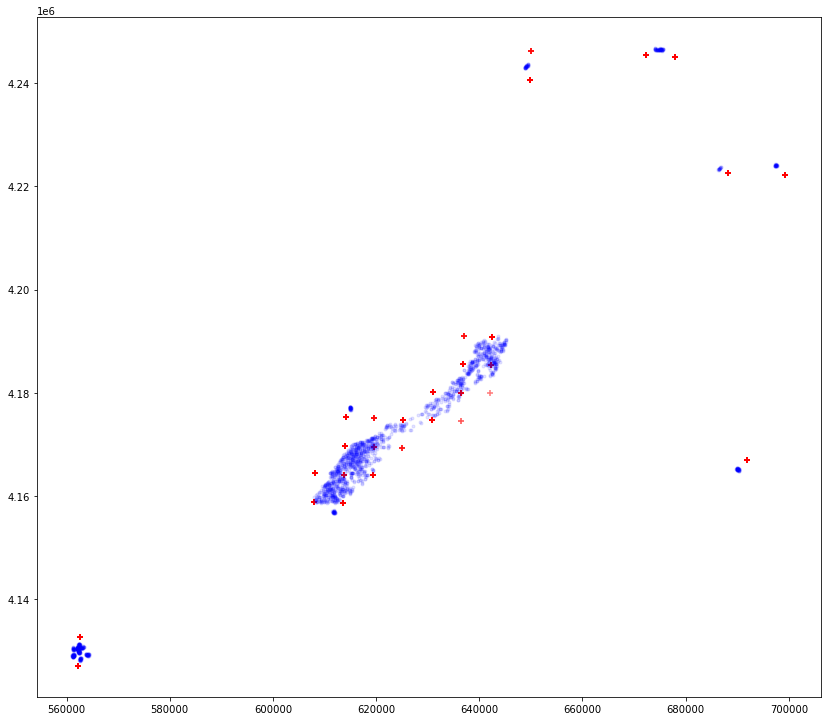

In [252]:
# Grid de nodos cercanos
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_reduced_grid.loc[df_related_precip.index_grid].plot(color='red', marker='+', alpha=0.3)

# gdf_reduced_grid.plot(ax=ax, marker='+')

gdf_loc.plot(ax=ax, color='blue', marker='.', alpha=0.1)

plt.show()

In [253]:
conn = sqlite3.connect(db_path)
c = conn.cursor()
sql = 'SELECT count(*) FROM precipitacion WHERE ID = 1'
c.execute(sql)
rows = c.fetchall()
print(rows[0][0])

conn.close()


0


In [262]:

print(df_related_precip.index_grid.values)
ind = np.unique(df_related_precip.index_grid)
node_ids = gdf_reduced_grid.loc[ind]['ID'].values
node_ids.sort()
print(node_ids)

[1769 1769 1769 ... 3000 3000 3000]
[1200 1291 1770 1771 1867 1868 1869 1973 1974 1975 1987 2078 2079 2080
 2081 2082 2184 2185 2186 2287 2288 2390 2391 2999 3001 3305 3412 3416
 3417]


In [264]:
# Leo del fichero de precipitaciones las estimaciones para los nodos más próximos a los puntos de muestreo.
# Los inserto en SQLite

# Apertura de conexión con la base de datos
conn = sqlite3.connect(db_path)
# generación de cursor para interaccionar con la base de datos
c = conn.cursor()

current_time = int(round(time.time())) # control de tiempo de la iteración

# Para cada uno de los nodos cercanos a las ubicaciones de interés
closest_grid_ids.sort()

for col in closest_grid_ids:
    print(f'Working on column number {col}. Please wait...')
    
    # checking previous insertions
    sql = f'SELECT count(*) FROM precipitacion WHERE ID = {col}'
    c.execute(sql)
    rows = c.fetchall()
    num_rows = rows[0][0]
    if num_rows > 0 :
        # previous insertions where done. 
        print('\tPrevious insertions where already done.')
    else:
        print(f'\tInserting precipitation data for node number = {col}')
        # Leo la fechas (columna 0) y las medidas de precipitación interpoladas (columna 'col')
        read = pd.read_csv(precip_path, header=None, usecols=[0, col], delim_whitespace=True)
        # Genero un DataFrame con el resultado obtenido
        df_precip = pd.DataFrame(read)
        # Verificación por pantalla de lectura
        print(df_precip.head())

        # Renombro las columnas del DataFrame obtenido
        df_precip.columns = ['fecha', 'precipitacion']
        
        # Cambio el formato del campo 'fecha' para que se gestione como fecha  (no como cadena de caracteres)
        df_precip['fecha'] = pd.to_datetime(df_precip['fecha'], format='%Y%m%d')
        # Genero elcampo que representa a la localización de la estación de medida real
        df_precip['ID'] = np.zeros(df_precip['fecha'].values.size, dtype='int') + col

        # print(df_precip[['ID', 'fecha', 'precipitacion']].info())
        # print(df_precip[['ID', 'fecha', 'precipitacion']].head())

        # Agrego esta información a la base de datos SQLite
        df_precip[['ID', 'fecha', 'precipitacion']].to_sql('precipitacion', conn, if_exists='append', index=False)
    
    # timing: muestro por pantalla el tiempo que ha tardado en realizar esta iteración 
    # (lectura de fichero + inserción en base de datos)
    new_time = int(round(time.time()))
    print(f'--> iteration time = {new_time - current_time} s')
    current_time = new_time
        
    """for r in pd.read_csv(precip_path, header=None, usecols=[0, col], delim_whitespace=True, chunksize=300):
        # df_precip = pd.DataFrame(reader.get_chunk(50))
        df_precip = pd.DataFrame(r)
        # print(f'\tChunk read.')
        print(df_precip.head())


        df_precip.columns = ['fecha', 'precipitacion']

        df_precip['fecha'] = pd.to_datetime(df_precip['fecha'], format='%Y%m%d')
        df_precip['ID'] = np.zeros(df_precip['fecha'].values.size, dtype='int') + col

        # print(df_precip[['ID', 'fecha', 'precipitacion']].info())
        # print(df_precip[['ID', 'fecha', 'precipitacion']].head())


        df_precip[['ID', 'fecha', 'precipitacion']].to_sql('precipitacion', conn, if_exists='append', index=False)
        # break
    """
    
    # if col > 1000:
    #    break

# Cierro la conexión con la base de datos SQLite
conn.close()


Working on column number 1200. Please wait...
	Inserting precipitation data for node number = 1200
       0      1200
0  19510101   0.00
1  19510102  18.09
2  19510103   3.27
3  19510104   0.27
4  19510105   0.00
--> iteration time = 324 s
Working on column number 1291. Please wait...
	Inserting precipitation data for node number = 1291
       0      1291
0  19510101   0.00
1  19510102  17.66
2  19510103   1.91
3  19510104   0.49
4  19510105   0.00
--> iteration time = 325 s
Working on column number 1770. Please wait...
	Inserting precipitation data for node number = 1770
       0     1770
0  19510101  0.00
1  19510102  2.94
2  19510103  0.00
3  19510104  0.00
4  19510105  0.00
--> iteration time = 304 s
Working on column number 1771. Please wait...
	Inserting precipitation data for node number = 1771
       0     1771
0  19510101  0.00
1  19510102  1.61
2  19510103  0.00
3  19510104  0.00
4  19510105  0.00
--> iteration time = 129 s
Working on column number 1867. Please wait...
	Inser

**Genero el fichero de salida de precipitaciones**

Tendrá por columnas: 

    Fecha,FID1,FID2,...,FIDN

donde 

- *Fecha*, será la fecha en la que se interpoló la precipitación (formato *YYYY-MM-DD*), y
- *FIDx*, representará la precipitación interpolada al nodo más cercano a la estación cuyo ID es *FIDx* (título del campo).

In [ ]:
# dataframe con asociaciones entre lugares de muestreo y nodos de malla de precipitacion más cercano
print(df_related_precip.info())

In [ ]:
print(gdf_reduced_grid.info())

In [ ]:
# Consulta de medidas de precipitación cuyo ID esté entre las estaciones proporcionadas en el fichero de entrada

# closest_grid_ids = np.sort(gdf_reduced_grid.loc[ind]['grid-point-number'].values)

# print(closest_grid_ids)

# Apertura de conexión con la base de datos
conn = sqlite3.connect(db_path)

dt = df_related_precip.loc[0]
id_close = gdf_reduced_grid.loc[dt['index_grid']]['ID']
id_sample = df_loc.loc[dt['index_location']]['FID']
    
df_data_precip = pd.read_sql(f'SELECT fecha, precipitacion FROM precipitacion WHERE ID={id_close}', conn)
df_data_precip.columns = ['fecha', str(id_sample)]
# print(df_data_precip)

for ind in df_related_precip.index:
    dt = df_related_precip.loc[ind]
    # print(dt)
    # print(type(dt))
    # print(dt['distance_m'])
    # print(type(dt['distance_m']))
    # break
    # getting precipitation node closest to this sampling location
    id_close = gdf_reduced_grid.loc[dt['index_grid']]['ID']
    id_sample = df_loc.loc[dt['index_location']]['FID']
    # print(f'(FID_sample, ID_grid, distance) = ({id_sample}, {id_close}, {dt["distance_m"]})')
    df_p = pd.read_sql(f'SELECT fecha, precipitacion FROM precipitacion WHERE ID={id_close}', conn)
    df_p.columns = ['fecha', str(id_sample)]
    df_data_precip = pd.concat([df_data_precip, df_p[[str(id_sample)]]], axis=1, join='inner')
     #break
    
conn.close()

print(df_data_precip.info())

precipitaciones_out = os.path.join(output_dir, 'historico_precipitaciones.csv')
df_data_precip.to_csv(precipitaciones_out, index=False, header=True)

#### 3. Piezometry database

La piezometría es accesible a través de una URL que apunta a un fichero alojado en la web del Ministerio de Transición Ecológica y Reto Demográfico. Está comprimido en formato ZIP. Contiene una base de datos MS Access con dos pestañas. La primera contiene, entre otras, información de la ubicación del punto en el que tomó la medida. La segunda, estación, medida piezométrica y fecha.

Vamos a homogeneizar los formatos de los ficheros de entrada. Para ello, generaremos un fichero CSV por cada una de las tablas contenidas en la base de datos MS Access de la piezometría.

In [ ]:
piezometers_path = os.path.join(data_dir, 'piezometers.csv')
levels_path = os.path.join(data_dir, 'levels_piezometry.csv')

In [ ]:
# Descarga del fichero de datos piezométricos
prefix, name = os.path.split(piezometry_url)
piezo_path = os.path.join(data_dir, name)

piezo_res = 1
if not os.path.exists(piezo_path):
    piezo_res = get_url(piezometry_url, data_dir)
else:
    print(f'"{piezo_path}" already downloaded.')

In [ ]:
df_piezometers = None
df_levels = None

# Si existen los CSV de piezometros y niveles piezometricos, los cargamos en memoria
if os.path.exists(piezometers_path):
    df_piezometers = pd.read_csv(piezometers_path)
if os.path.exists(levels_path):
    df_levels = pd.read_csv(levels_path)
    
# Si no existe uno de los dos ficheros y la descarga del ZIP de piezometría se ha 
# llevado a cabo sin problemas, descomprimimos, leemos la base de datos y 
# almacenamos cada tabla en sendos dataframes.
if (df_levels is None or df_piezometers is None) and piezo_res > 0:
    # Descompresión del fichero
    root, name = os.path.split(piezometry_url)
    piezo_path = os.path.join(data_dir, name)

    if unzip(piezo_path, data_dir) == 0:
        # Lectura del fichero de base de datos
        piezo_db_path = glob.glob(os.path.join(data_dir, '*.mdb'))
        print(f"MS Access database file: '{piezo_db_path[0]}'")
        df_piezometers, df_levels = read_db_piezometry(piezo_db_path[0])

In [ ]:
print(df_piezometers.info())

In [ ]:
df_piezometers.head()

In [ ]:
print(df_levels.info())

In [ ]:
print(df_levels.head())

#### Saving piezometry dataframes

In [ ]:
df_piezometers.to_csv(piezometers_path, index=False)
df_levels.to_csv(levels_path, index=False)

**Creación de la infraestructura y contenidos de piezometros en la base de datos**

In [ ]:
"""
# Esta parte no es necesaria. La tabla se genera/actualiza a través de la 
# llamada al método "to_sql" del dataframe.

# Creacion de la tabla para los piezometros

conn = sqlite3.connect(db_path)
c = conn.cursor()

fields = OrderedDict()
fields['COD_DEM_ID'] = 'INT'
fields['NOM_DEM'] = 'VARCHAR(128)'
fields['IDPIEZ'] = 'INT'
fields['PIEZCOD'] = 'VARCHAR(255)'
fields['PIEZCOD_EU'] = 'VARCHAR(255)'
fields['PIEZNOM'] = 'VARCHAR(255)'
fields['PIEZNOM2'] = 'VARCHAR(255)'
fields['ESTADO'] = 'VARCHAR(64)'
fields['CX89_HUSO30'] = 'DECIMAL(20,10)'
fields['CY89_HUSO30'] = 'DECIMAL(20,10)'
fields['PIEZHUSO'] = 'INT'
fields['CZ'] = 'DECIMAL(10,5)'
fields['PIEZPROF'] = 'INT'
fields['PIEZOBS'] = 'VARCHAR(255)'
fields['LITO'] = 'VARCHAR(255)'
fields['MAS_GEO_2016'] = 'VARCHAR(255)'
fields['NOM MAS GEO'] = 'VARCHAR(255)'
fields['MAS_CONTROL_2016'] = 'VARCHAR(255)'
fields['NOM MAS CONTROL'] = 'VARCHAR(255)'
fields['UUHH_GEO'] = 'VARCHAR(64)'
fields['NOM UH'] = 'VARCHAR(255)'
fields['PROVCOD'] = 'INT'
fields['PROVNOM'] = 'VARCHAR(255)'
fields['MUNICOD'] = 'INT'
fields['MUNINOM'] = 'VARCHAR(255)'
fields['PROVMUNICOD'] = 'INT'
fields['FASE'] = 'VARCHAR(64)'
fields['ESTADO'] = 'VARCHAR(64)'
fields['STATUS'] = 'VARCHAR(64)'
fields['Nºmedidas'] = 'INT'
fields['Cota_NPmsnm_min'] = 'DECIMAL(10,4)'
fields['Cota_NPmsnm_max'] = 'DECIMAL(10,4)'

list_fields = [f'`{k}` {v}' for k, v in fields.items()]

sql = f'CREATE TABLE IF NOT EXISTS piezometro ({", ".join(list_fields)}, PRIMARY KEY(IDPIEZ))'
print(sql)

c.execute(sql)
conn.commit()

conn.close()
"""

In [ ]:
# Generación de tabla e inserción de información de los piezometros
conn = sqlite3.connect(db_path)
c = conn.cursor()

try:
    df_piezometers.to_sql('piezometro', conn, if_exists='replace', index=False)
except ValueError as e:
    print(f'Se produjo la siguiente excepción al insertar información de los piezometros en la base de datos: \n\t{e}\n')
    

conn.close()

In [ ]:
# Consulta de verificación
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute("SELECT * FROM piezometro WHERE MUNINOM LIKE '%Medina del Campo%'")

for row in c.fetchall():
    print(row)

conn.close()

**Creación de la infraestructura y contenidos para las medidas de piezometría en la base de datos**

In [ ]:
# creacion de la tabla e inserción de las medidas de piezometría

conn = sqlite3.connect(db_path)
c = conn.cursor()

try:
    df_levels.to_sql('piezometria', conn, if_exists='replace', index=False)
except ValueError as e:
    print(f'Se produjo la siguiente excepción al insertar las mediciones de piezometría en la base de datos: \n\t{e}\n')
    

conn.close()

In [ ]:
# Consulta de verificación
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute("SELECT * FROM piezometria WHERE IDPIEZ = 3782 ORDER BY FechaP")

for row in c.fetchall():
    print(row)

conn.close()

#### Asociación entre punto de muestreo y piezómetro más próximo

Se tomará como distancia límite 5 km para que se considere esa asociación como válida.

In [ ]:
# Creo el objeto GeoDataFrame a partir del DataFrame de los piezómetros
geom = gpd.points_from_xy(df_piezometers.CX89_HUSO30, df_piezometers.CY89_HUSO30, crs='EPSG:25830')
gdf_piezometers = gpd.GeoDataFrame(df_piezometers, geometry=geom)

In [ ]:
print(gdf_piezometers.info())

In [ ]:
print(gdf_piezometers.head())

In [ ]:
# Comprobación de sistema de referencia de los puntos de muestreo
print(f'SR de los puntos de muestreo = {gdf_loc.crs}')

# Y de la ubicación de los piezómetros
print(f'SR de los puntos de muestreo = {gdf_piezometers.crs}')

**Muestro ubicaciones**

In [ ]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_piezometers.plot(color='red', marker='.', markersize=0.5)

gdf_loc.plot(ax=ax, color='blue', alpha=0.3, marker='.', markersize=0.5)

plt.show()

In [ ]:
# Locations limits
min_lon = gdf_loc.Lon_ETRS89.min()
max_lon = gdf_loc.Lon_ETRS89.max()
min_lat = gdf_loc.Lat_ETRS89.min()
max_lat = gdf_loc.Lat_ETRS89.max()

b_limits = (gdf_piezometers.CX89_HUSO30.values >= min_lon - 5000) & (gdf_piezometers.CX89_HUSO30.values <= max_lon + 5000)
b_limits = b_limits & (gdf_piezometers.CY89_HUSO30.values >= min_lat - 5000) & (gdf_piezometers.CY89_HUSO30.values <= max_lat + 5000)
print(f'Número de piezómetros en los límites de las localizaciones de muestreo = {b_limits.sum()}')

In [ ]:
# Zoom a la zona de muestreo

gdf_reduced_piezometers = gdf_piezometers[b_limits]
# gdf_reduced_grid = gdf_reduced_grid.to_crs('EPSG:23030')
gdf_reduced_piezometers = gdf_reduced_piezometers.to_crs('EPSG:25830')

In [ ]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_reduced_piezometers.plot(color='red', marker='+')

gdf_loc.plot(ax=ax, color='blue', alpha=0.3, marker='.')

plt.show()

In [ ]:
def distances(gdf1, gdf2):
    """
    """
    # determino las distancias entre cada punto de gdf1 y gdf2
    pairs = {'index_location': [], 'index_grid': [], 'distance_m': []}
    # para cada localización de medida...
    for ind in gdf1.index:
        location = gdf1.loc[[ind]].geometry.values[0]
        # print(location)
        # Se busca el punto más cercano en la malla de precipitaciones
        dist = gdf2.geometry.distance(location)
        #print(f'Distancia mínima (m) = {dist.values.min()}')
        index_grid = gdf2.index[dist.values.argmin()]
        #print(gdf_reduced_grid.loc[[index_grid]])
        pairs['index_location'].append(ind)
        pairs['index_grid'].append(index_grid)
        pairs['distance_m'].append(dist.values.min())

    return pairs

pairs = distances(gdf_loc, gdf_piezometers)

print(f'Número de distancias medidas = {len(pairs["distance_m"])}')
for l, g, d in zip(pairs['index_location'], pairs['index_grid'], pairs['distance_m']):
    print(f'(index_location, index_grid, distance_m) = ({l}, {g}, {d})')
    
# Guardo el diccionario de correspondencias como dataframefichero temporal en el directorio de resultados
df_related_piezo = pd.DataFrame.from_dict(pairs)
related_piezo_path = os.path.join(output_dir, 'correspondencias_piezometros.csv')
df_related_piezo.to_csv(related_piezo_path, index=False)

Estadísticas de las distancias entre localizaciones de muestreo y piezómetros cercanos

In [ ]:
dist = df_related_piezo['distance_m'].values
message = '(media, desviación estándar, mediana, máximo, mínimo) = ({:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}) m'
print(message.format(dist.mean(), dist.std(), np.median(dist), dist.max(), dist.min()))

In [ ]:
index_closest_piezometers = np.unique(df_related_piezo.index_grid.values)
print(len(index_closest_piezometers))

In [ ]:
sns.histplot(df_related_piezo['distance_m'].values, bins=15)
#plt.hist(pairs['distance_m'], bins=15)
plt.title('Distancia (m) entre localización de los puntos de muestreo y los piezómetros')
plt.xlabel("Distancia (m)")
plt.show()

No todas las correspondencias entre lugar de muestreo y piezómetros son válidas. Sólo lo son aquellas cuya distancia es inferior a 5 km.

In [ ]:
# Filtro para quitar las distancias mayores de 5 km (5000 m)
df_related_filtered_piezo = df_related_piezo[df_related_piezo['distance_m'] <= 5000]
print(f'Número de correspondencias válidas = {len(df_related_filtered_piezo.index)} (de {len(df_loc.index)} localizaciones de muestreo)')

Mostramos el histograma de distancias, para aquellas menores de 5000 m.

In [ ]:
sns.histplot(df_related_filtered_piezo['distance_m'].values, bins=15)
#plt.hist(pairs['distance_m'], bins=15)
plt.title('Distancia (m) entre localización de los puntos de muestreo y los piezómetros')
plt.xlabel("Distancia (m)")
plt.show()

y las correspondientes estadísticas descriptivas

In [ ]:
dist = df_related_filtered_piezo['distance_m'].values
message = '(numero_distancias, media, desviación estándar, mediana, máximo, mínimo) = ({}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}) m'
print(message.format(len(dist), dist.mean(), dist.std(), np.median(dist), dist.max(), dist.min()))

In [ ]:
# gráfica de caja y bigote

sns.boxplot(data=df_related_filtered_piezo, y='distance_m')


In [ ]:
# gráfica de violín

sns.set_theme(style="whitegrid")

sns.violinplot(data=df_related_filtered_piezo, y='distance_m')

In [ ]:
# Vuelco el contenido del dataframe de correspondencias entre localizaciones de muestreo y piezómetros a un fichero
related_filtered_piezo_path = os.path.join(output_dir, 'correspondencias_filtradas_piezometros.csv')
df_related_filtered_piezo.to_csv(related_filtered_piezo_path, index=False)

In [ ]:
# Fichero de salida para las medidas piezométricas

# Apertura de conexión con la base de datos
conn = sqlite3.connect(db_path)

dt = df_related_filtered_piezo.loc[0]
id_close = gdf_piezometers.loc[dt['index_grid']]['IDPIEZ']
id_sample = df_loc.loc[dt['index_location']]['FID']
print(f'(id_sample, id_close) = ({id_sample}, {id_close})')

df_data_piezo = pd.read_sql(f'SELECT FechaP, `Prof_NP_leída` FROM piezometria WHERE IDPIEZ={id_close}', conn)
df_data_piezo.columns = ['fecha', str(id_sample)]
# print(df_data_precip)

for ind in df_related_filtered_piezo.index[1:]:
    dt = df_related_filtered_piezo.loc[ind]
    # print(dt)
    # print(type(dt))
    # print(dt['distance_m'])
    # print(type(dt['distance_m']))
    # break
    # getting precipitation node closest to this sampling location
    id_close = gdf_piezometers.loc[dt['index_grid']]['IDPIEZ']
    id_sample = df_loc.loc[dt['index_location']]['FID']
    # print(f'(id_sample, id_close) = ({id_sample}, {id_close})')
    print(f'(FID_sample, ID_piezometer, distance) = ({id_sample}, {id_close}, {dt["distance_m"]})')
    df_p = pd.read_sql(f'SELECT FechaP, `Prof_NP_leída` FROM piezometria WHERE IDPIEZ={id_close}', conn)
    df_p.columns = ['fecha', str(id_sample)]
    #df_data_piezo = pd.concat([df_data_piezo, df_p[[str(id_sample)]]], axis=1)
    df_data_piezo = df_data_piezo.merge(df_p, left_on='fecha', right_on='fecha', how='outer')
    
conn.close()

print(df_data_piezo.info())

piezometrias_out = os.path.join(output_dir, 'historico_piezometrias.csv')
df_data_piezo.to_csv(piezometrias_out, index=False, header=True)

In [ ]:
print(df_data_piezo.sort_values(by=['fecha']))